In [ ]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import tensorflow as tf

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
!unzip "/content/drive/My Drive/Projects_Colab/Dogs/dogs.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1357.jpg  
  inflating: images/Images/n02108089-boxer/n0210

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

  def forward(self, input):
        output = self.main(input)
        return output.view(-1)

In [ ]:
netD = Discriminator()
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

  def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
netG = Generator()
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
seed = random.randint(1, 1000)
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=0.1
        
)

train_generator = datagen.flow_from_directory(
        "/content/images/Images",
        target_size=(64,64),
        batch_size=128,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)


Found 18571 images belonging to 120 classes.


/content/images/Images/n02106550-Rottweiler/n02106550_4063.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 18571 + 1) instead
  after removing the cwd from sys.path.


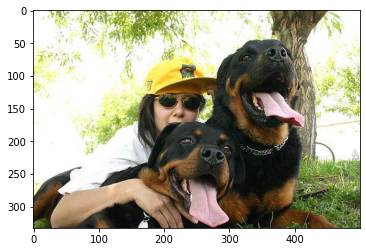

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
import cv2
img = plt.imread(img)
plt.imshow(img)


In [ ]:
img.shape

(333, 500, 3)

In [ ]:
lr = 0.0002
batch_size =128
image_size = 64
channels_img =3
channels_noise = 100
epochs = 1

features_d = 64
features_g = 64

In [ ]:
my_transforms = transforms.Compose([
                                    transforms.Resize([64,64]),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])
dataset = datasets.ImageFolder(root='/content/images/Images/',transform=my_transforms)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True )

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
import time
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
from torch.autograd import Variable
import torchvision.utils as vutils
%matplotlib inline

Streaming output truncated to the last 5000 lines.
          [ 4.8525e-01,  4.6769e-01,  5.8029e-01,  ..., -1.7115e-01,
           -1.2457e-01, -2.2949e-01]],

         [[ 1.0137e-01,  1.9744e-01,  1.7912e-01,  ...,  3.5342e-01,
            2.9037e-01,  1.8761e-01],
          [ 1.7440e-01,  1.1761e-01,  1.1538e-01,  ...,  2.9847e-01,
            1.4090e-01,  2.1144e-01],
          [ 2.3829e-01,  1.7531e-01,  1.1077e-01,  ...,  1.8452e-01,
            9.2844e-02,  4.4708e-02],
          ...,
          [-1.5378e-01, -5.3725e-01, -5.2410e-01,  ..., -4.2041e-01,
           -4.3522e-01, -4.4946e-01],
          [ 9.4628e-02, -1.1880e-01, -2.0805e-01,  ..., -3.9550e-01,
           -3.8134e-01, -4.4247e-01],
          [ 1.6873e-01,  1.6243e-01,  7.7941e-03,  ..., -4.1662e-01,
           -4.1317e-01, -3.9523e-01]]]], grad_fn=<TanhBackward>)
tensor([[[[-2.6981e-01, -1.9929e-01, -1.2566e-01,  ..., -1.1159e-01,
           -2.4294e-01, -2.2584e-01],
          [-4.1979e-01, -3.2378e-01, -3.3005e-01,

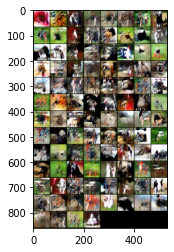

In [ ]:
for epoch in range(20):

    for i, data in enumerate(dataloader, 0):
        print(i)
        
        # 1st Step: Updating the weights of the neural network of the discriminator
        print("step 1 ")
        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        print("training real")
        real, _ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        print("training fake")
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        print("backpropogation")
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator
        print("step2")
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        fakeset=[]
        fakedataset=[]
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print("step3")
        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data[0], errG.data[0]))
        if i % 10 == 0:
           # vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
            fake = netG(noise)
            fakeset.append(fake)
            fakedataset.append(fake)
            print(fake)
            print(fake.data)
            grid = vutils.make_grid(fake.data,normalize= True )
            print(grid)
            
            ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
            print(ndarr)
            im = Image.fromarray(ndarr)
            print("image")
            print(im)
            imshow(np.asarray(im))
            im.show() 
            time.sleep(6)
            
            


            vutils.save_image(fake.data, '/content/Results/fake_samples_epoch_%03d.png' % (epoch), normalize = True)


In [ ]:
import pandas as pd 
df=pd.DataFrame(fakeset)
df["fakedataset"]=fakedataset
from google.colab import files
df.to_csv('tensor.csv') 
files.download('tensor.csv')